In [1]:
from datasets import load_dataset

/home/rahi/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Load an image dataset from the internet
dataset = load_dataset('UrbanSyn/UrbanSyn', split='train', data_files='rgb/*_00*.png')
dataset = dataset.train_test_split(1)

train_dataset = dataset['train']
test_dataset = dataset['test']

Generating train split: 99 examples [00:00, 7065.32 examples/s]


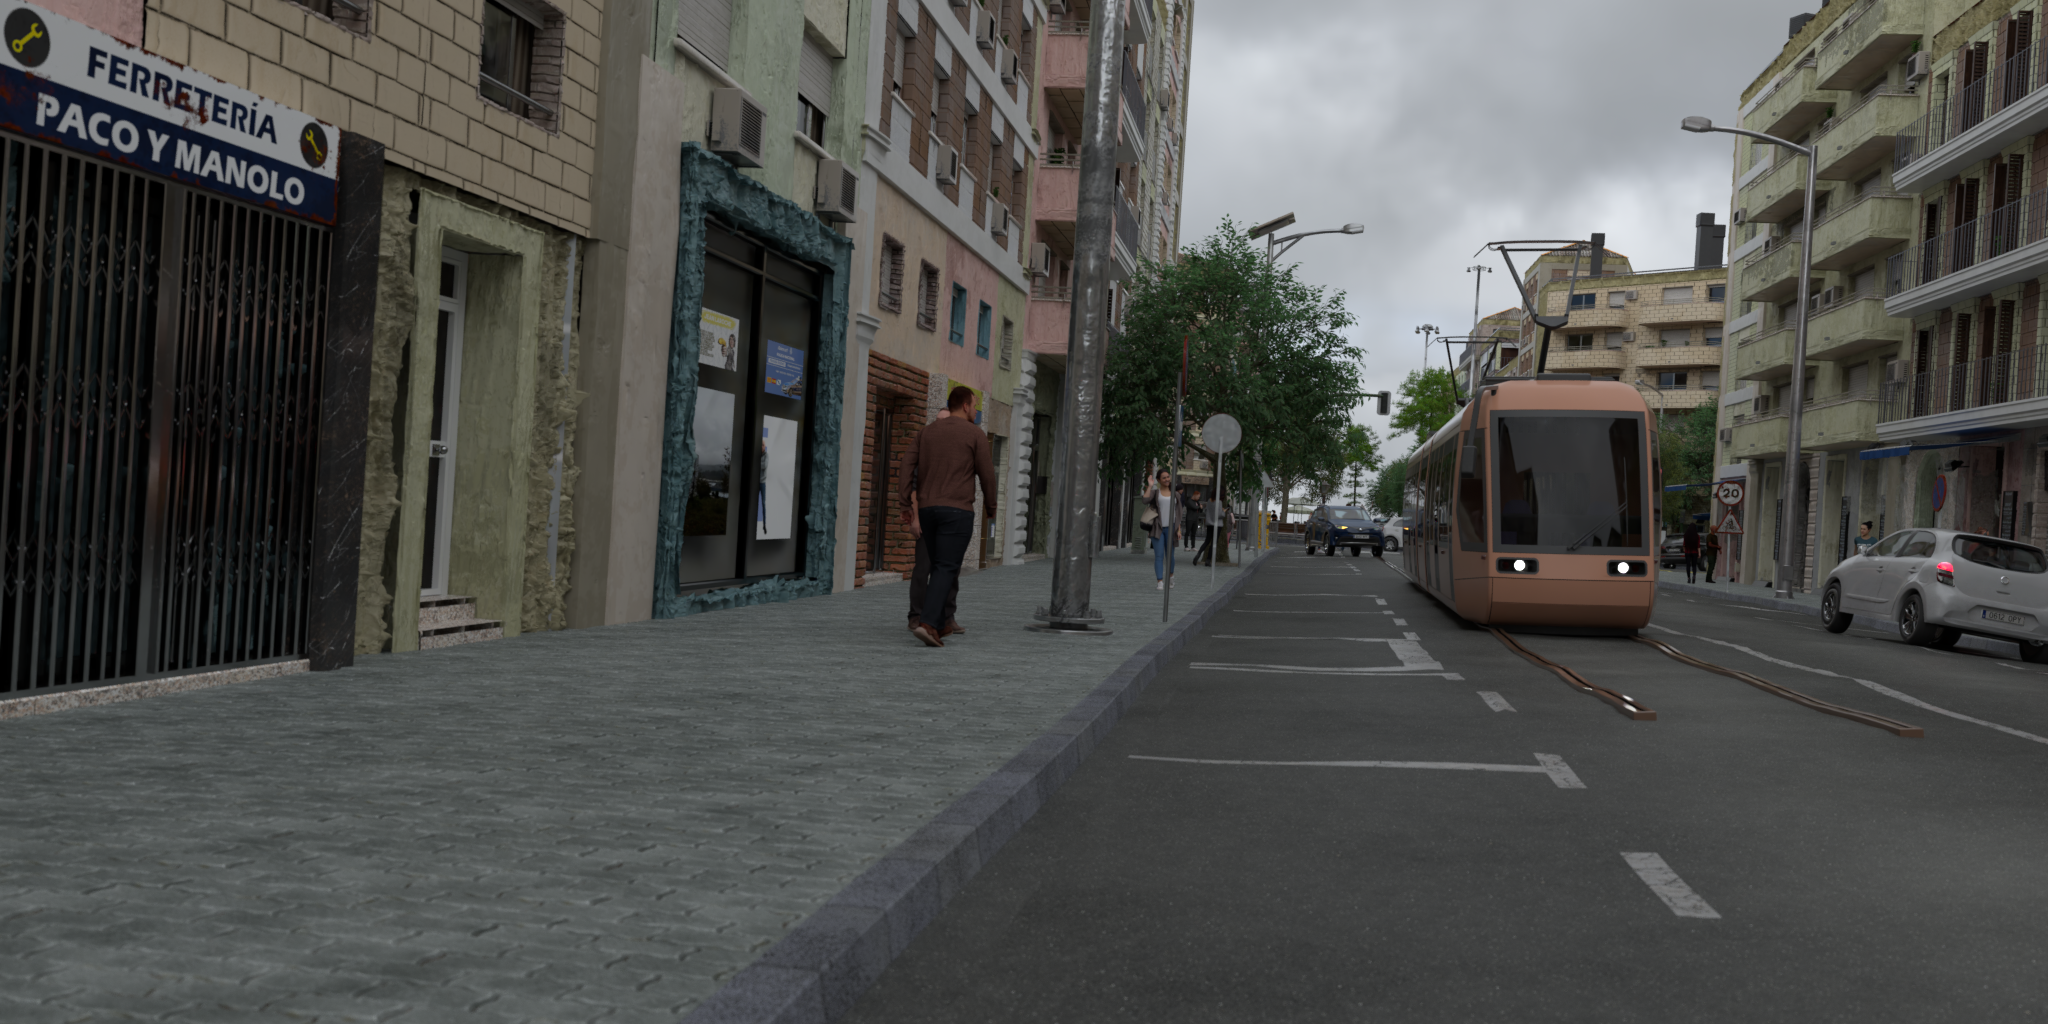

In [5]:
train_dataset["image"][0]

In [6]:
import torch
from torchvision import transforms

# Convert the PIL image above to Torch Tensor
preprocess = transforms.ToTensor()

# Get a sample image in the test dataset
test_sample_pil = test_dataset[0]["image"]
test_sample = preprocess(test_sample_pil).unsqueeze(0) 
print(test_sample)

tensor([[[[0.0118, 0.0118, 0.0157,  ..., 0.4706, 0.4863, 0.4902],
          [0.0157, 0.0157, 0.0157,  ..., 0.4824, 0.4941, 0.4980],
          [0.0157, 0.0157, 0.0157,  ..., 0.4902, 0.4980, 0.4980],
          ...,
          [0.4471, 0.4471, 0.4549,  ..., 0.3020, 0.3020, 0.3059],
          [0.4471, 0.4549, 0.4588,  ..., 0.3059, 0.3020, 0.3020],
          [0.4510, 0.4706, 0.4627,  ..., 0.3098, 0.3098, 0.3137]],

         [[0.0118, 0.0118, 0.0118,  ..., 0.4353, 0.4510, 0.4588],
          [0.0118, 0.0118, 0.0118,  ..., 0.4431, 0.4588, 0.4667],
          [0.0118, 0.0118, 0.0118,  ..., 0.4510, 0.4627, 0.4706],
          ...,
          [0.4549, 0.4588, 0.4667,  ..., 0.3176, 0.3176, 0.3216],
          [0.4588, 0.4667, 0.4706,  ..., 0.3255, 0.3176, 0.3176],
          [0.4627, 0.4824, 0.4784,  ..., 0.3255, 0.3294, 0.3294]],

         [[0.0078, 0.0078, 0.0078,  ..., 0.3922, 0.4118, 0.4275],
          [0.0078, 0.0078, 0.0078,  ..., 0.4000, 0.4196, 0.4314],
          [0.0118, 0.0078, 0.0078,  ..., 0

In [7]:
import torch.nn.functional as F
import numpy as np
from PIL import Image

input_shape = (1, 3, 1024, 2048)

def postprocess(output_tensor, input_image_pil):

    # Upsample the output to the original size
    output_tensor_upsampled = F.interpolate(
        output_tensor, input_shape[2:], mode="bilinear",
    )

    # Get top predicted class and convert to numpy
    output_predictions = output_tensor_upsampled[0].argmax(0).byte().detach().numpy().astype(np.uint8)

    # Overlay over original image
    color_mask = Image.fromarray(output_predictions).convert("P")

    # Create an appropriate palette for the Cityscapes classes
    palette = [
        128, 64, 128, 244, 35, 232, 70, 70, 70, 102, 102, 156,
        190, 153, 153, 153, 153, 153, 250, 170, 30, 220, 220, 0,
        107, 142, 35, 152, 251, 152, 70, 130, 180, 220, 20, 60,
        255, 0, 0, 0, 0, 142, 0, 0, 70, 0, 60, 100, 0, 80, 100,
        0, 0, 230, 119, 11, 32]
    palette = palette + (256 * 3 - len(palette)) * [0]
    color_mask.putpalette(palette)
    out = Image.blend(input_image_pil, color_mask.convert("RGB"), 0.5)
    return out

# Setup model in floating point

In [8]:
from qai_hub_models.models.ffnet_40s.model import FFNet40S
model = FFNet40S.from_pretrained().model.eval()

# Run sample output through the model
test_output_fp32 = model(test_sample)
test_output_fp32

postprocess(test_output_fp32, test_sample_pil)

100%|██████████| 55.8M/55.8M [04:49<00:00, 193kB/s] 


Done
cityscapes_segmentation requires repository https://github.com/Qualcomm-AI-research/FFNet.git . Ok to clone? [Y/n] Cloning https://github.com/Qualcomm-AI-research/FFNet.git to /home/rahi/.qaihm/models/cityscapes_segmentation/v2/Qualcomm-AI-research_FFNet_git...
Done


ModuleNotFoundError: No module named 'scipy.ndimage'